In [6]:
from pytket.extensions.qiskit.backends.aer import AerBackend
from pytket.circuit import BasisOrder, Circuit

backend = AerBackend()

c = Circuit(2, 2)
c.H(0)
c.CX(0, 1)
c.measure_all()

c = backend.get_compiled_circuit(c)
handle = backend.process_circuit(c, n_shots=10)
counts = backend.get_result(handle).get_counts()
print(counts)

Counter({(0, 0): 8, (1, 1): 2})


In [7]:
backend.get_result(handle).get_counts()

Counter({(0, 0): 8, (1, 1): 2})

In [8]:
backend.get_result(handle).get_shots()

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=uint8)

In [9]:
test_handle = backend.get_result(handle)

In [10]:
test_handle.c_bits

{c[0]: 0, c[1]: 1}

# Simplest example

In [11]:
from pytket.extensions.qiskit.backends.aer import AerBackend
from pytket.circuit import BasisOrder, Circuit

backend = AerBackend()

c = Circuit(1,1)
c.H(0)
c.measure_all()

c = backend.get_compiled_circuit(c)
handle = backend.process_circuit(c, n_shots=10)
counts = backend.get_result(handle).get_counts()
print(counts)

Counter({(1,): 6, (0,): 4})


In [13]:
test_handle = backend.get_result(handle)

In [14]:
test_handle.get_shots()

array([[1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [17]:
from pytket.utils.outcomearray import OutcomeArray

In [ ]:
OutcomeArray.from_readouts(bit_strings

In [16]:
test_handle._shots

OutcomeArray([[128],
              [  0],
              [  0],
              [128],
              [  0],
              [  0],
              [128],
              [128],
              [128],
              [128]], dtype=uint8)

In [7]:
seed = 3
import numpy as np
n_shots = 1000

rng = np.random.default_rng(seed)
randnums = rng.random(n_shots).tolist()

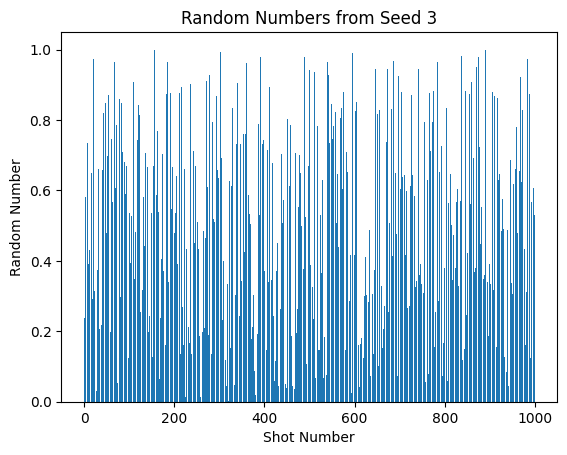

In [8]:
# Plot the random numbers as bar chart
import matplotlib.pyplot as plt
plt.bar(range(n_shots), randnums)
# Show the plot
plt.xlabel('Shot Number')
plt.ylabel('Random Number')
plt.title('Random Numbers from Seed {}'.format(seed))
plt.show()

In [10]:
type(randnums[0])

float

In [11]:
print(f"randnums dtype: {type(randnums[0])}")
print(f"randnums min: {np.min(randnums)}")
print(f"randnums max: {np.max(randnums)}")
# Check if any values are exactly 1.0 (shouldn't be)
print(f"randnums contains 1.0: {1.0 in randnums}")

randnums dtype: <class 'float'>
randnums min: 0.001148413743897403
randnums max: 0.9998030282851982
randnums contains 1.0: False


In [31]:
import cupy as cp
import numpy as np
import cuquantum.custatevec as cusv
from cuquantum import cudaDataType
from cuquantum.bindings.custatevec import SamplerOutput
from collections import Counter

# Minimal setup for a single qubit H gate
n_qubits = 1
n_shots = 200 # Or 10000 for better statistics, but 200 for initial test
seed = 42 # For reproducibility

# 1. Initialize state |0>
sv_array = cp.zeros(2**n_qubits, dtype=cp.complex128)
sv_array[0] = 1.0 + 0.0j # |0> state

# 2. Apply Hadamard manually (equivalent to H(0))
sqrt2_inv = 1 / np.sqrt(2)
h_matrix = cp.array([[sqrt2_inv, sqrt2_inv],
                    [sqrt2_inv, -sqrt2_inv]], dtype=cp.complex128)
sv_array = cp.dot(h_matrix, sv_array)

print("Statevector after H gate (minimal test):", cp.asnumpy(sv_array))

# Sampler
# This is the most direct binding to the C API functions for handle creation/destruction.
# If these also give AttributeError, then there's a significant version mismatch or installation issue.
handle = None
try:
    # Attempt to call the C API's handle creation function directly
    # This function should return an intptr_t for the handle.
    handle = cusv.custatevecCreate() # <--- Re-attempting with this C-API style name
    
    sampler_descriptor, size_t = cusv.sampler_create(
        handle,
        sv_array.data.ptr,
        cudaDataType.CUDA_C_64F,
        n_qubits,
        n_shots,
    )

    sampled_integers = np.empty(n_shots, dtype=np.int32)
    bit_ordering = [0] # Single qubit at index 0
    rng = np.random.default_rng(seed)
    randnums = rng.random(n_shots).tolist()

    cusv.sampler_preprocess(
        handle=handle,
        sampler=sampler_descriptor,
        extra_workspace=0,
        extra_workspace_size_in_bytes=0,
    )

    cusv.sampler_sample(
        handle=handle,
        sampler=sampler_descriptor,
        bit_strings=sampled_integers.ctypes.data,
        bit_ordering=bit_ordering,
        bit_string_len=n_qubits,
        randnums=randnums,
        n_shots=n_shots,
        output=SamplerOutput.RANDNUM_ORDER,
    )

    # Clean up sampler descriptor
    cusv.sampler_destroy(handle, sampler_descriptor) 

finally:
    # Ensure handle is destroyed even if errors occur
    if handle is not None:
        # Attempt to call the C API's handle destruction function directly
        cusv.custatevecDestroy(handle) # <--- Re-attempting with this C-API style name

# Now inspect sampled_integers
print("\nSampled Integers (raw from cuStateVec):", sampled_integers)
print(f"Number of 0s: {np.sum(sampled_integers == 0)}")
print(f"Number of 1s: {np.sum(sampled_integers == 1)}")

# Convert to a format like Pytket's expected readouts (list of lists of single bits)
readouts_for_counts = [[int(x)] for x in sampled_integers]

counts = Counter(tuple(shot) for shot in readouts_for_counts)
print("\nCounts (Pytket-like format):", counts)

Statevector after H gate (minimal test): [0.70710678+0.j 0.70710678+0.j]


AttributeError: module 'cuquantum.custatevec' has no attribute 'custatevecCreate'

In [24]:
from cuquantum.bindings._utils import handle_manager

ImportError: cannot import name 'handle_manager' from 'cuquantum.bindings._utils' (/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuquantum/bindings/_utils.cpython-310-x86_64-linux-gnu.so)